In [237]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import holidays
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline
# %config InlineBackend.figure_format = "retina"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

/var/folders/5r/_46vtm3167l75wv16plwtdq00000gq/T/ipykernel_23491/4071921336.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


## Load Training and Testing Data

In [178]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release",
         "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["post_month"]
del df["day"]
del df["month"]
df

,year,days_since_previous_release,release_post,date
id,,,,
50,2016,NaN,False,2016-02-15
123,2016,NaN,False,2016-02-15
173,2016,NaN,False,2016-02-15
156,2016,NaN,False,2016-02-15
133,2016,NaN,False,2016-02-15
...,...,...,...,...
378,2022,5.0,True,2022-01-25
379,2022,5.0,True,2022-09-08
380,2022,5.0,True,2022-12-07


In [179]:
df.query("release_post == True & days_since_previous_release.isnull()")

,year,days_since_previous_release,release_post,date
id,,,,


In [180]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [181]:
df = df[df["release_post"] == True].copy()

In [182]:
df = df[df["days_since_previous_release"] != 0].copy()

In [183]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})
del df["year"]

In [184]:
df = df.sort_values(by=["date"]).set_index("date")
daily = pandas.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(daily, method=None)
df["release_post"] = df["release_post"].fillna(False)

In [185]:
df = df.reset_index()
release_dates = list(df[df["release_post"] == True]["index"])
df["closest_release_date"] = df["index"].apply(lambda x : max([d for d in release_dates if d <= x]))
df["backfill"] = (df["index"] - df["closest_release_date"]).astype("timedelta64[D]")
df["days_since_previous_release"] = df["days_since_previous_release"].fillna(df["backfill"])
del df["backfill"]
del df["closest_release_date"]
df["future_release_date"] = df["index"].apply(lambda x : min([d for d in release_dates if d >= x]))
df["days_until_next_release"] = (df["future_release_date"] - df["index"]).astype("timedelta64[D]")
del df["future_release_date"]
df

,index,days_since_previous_release,release_post,days_until_next_release
0,2017-02-26,9.0,True,0.0
1,2017-02-27,1.0,False,19.0
2,2017-02-28,2.0,False,18.0
3,2017-03-01,3.0,False,17.0
4,2017-03-02,4.0,False,16.0
...,...,...,...,...
2134,2022-12-31,1.0,False,4.0
2135,2023-01-01,2.0,False,3.0
2136,2023-01-02,3.0,False,2.0
2137,2023-01-03,4.0,False,1.0


In [186]:
df["prob_of_release"] = (df["days_since_previous_release"] /
                         (df["days_since_previous_release"] + df["days_until_next_release"]))
del df["days_until_next_release"]

## Features

In [206]:
def get_features(df):
    # in addition to days_since_previous_release
    
    df["month_holidays"] = df["index"].apply(
        lambda x : len([h for h in nj_holidays if h.month == x.month and h.year == x.year]))
    
    df["weekday"] = df["index"].apply(lambda x : x.strftime("%A"))
    df["month"] = df["index"].apply(lambda x : x.strftime("%b"))
    
    df = pandas.get_dummies(df, columns=["weekday"], prefix="WD")
    df = pandas.get_dummies(df, columns=["month"], prefix="M")
    
    if "previous_release_post" not in df.columns:
        df["previous_release_post"] = df["release_post"].shift().fillna(False)
        df["previous_release_post"] = df["previous_release_post"].apply(int)
        del df["release_post"]
    
    return df

In [194]:
df = get_features(df)

In [195]:
df

,index,days_since_previous_release,prob_of_release,month_holidays,WD_Friday,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,...,M_Feb,M_Jan,M_Jul,M_Jun,M_Mar,M_May,M_Nov,M_Oct,M_Sep,previous_release_post
0,2017-02-26,9.0,1.00,4,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2017-02-27,1.0,0.05,4,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,2017-02-28,2.0,0.10,4,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,2017-03-01,3.0,0.15,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2017-03-02,4.0,0.20,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,2022-12-31,1.0,0.20,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2135,2023-01-01,2.0,0.40,3,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2136,2023-01-02,3.0,0.60,3,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2137,2023-01-03,4.0,0.80,3,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


## Model-Building and Evaluation

In [196]:
train_df = df[0:int(len(df) * 0.90)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1925 214


In [197]:
features = [c for c in df.columns if c not in ["index", "prob_of_release", "release_post"]]
features

['days_since_previous_release',
 'month_holidays',
 'WD_Friday',
 'WD_Monday',
 'WD_Saturday',
 'WD_Sunday',
 'WD_Thursday',
 'WD_Tuesday',
 'WD_Wednesday',
 'M_Apr',
 'M_Aug',
 'M_Dec',
 'M_Feb',
 'M_Jan',
 'M_Jul',
 'M_Jun',
 'M_Mar',
 'M_May',
 'M_Nov',
 'M_Oct',
 'M_Sep',
 'previous_release_post']

In [212]:
scaler = StandardScaler()
scaler.fit(train_df[["days_since_previous_release", "month_holidays"]])
train_df[["days_since_previous_release", "month_holidays"]] = scaler.transform(
    train_df[["days_since_previous_release", "month_holidays"]])
test_df[["days_since_previous_release", "month_holidays"]] = scaler.transform(
    test_df[["days_since_previous_release", "month_holidays"]])

In [238]:
reg = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
              scoring="neg_mean_absolute_percentage_error",
              cv=3)
reg.fit(train_df[features], train_df["prob_of_release"])

RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=3,
        scoring='neg_mean_absolute_percentage_error')

In [239]:
reg.best_score_

-0.38977659924634445

In [240]:
test_df["predicted"] = reg.predict(test_df[features])

In [241]:
mape(test_df["prob_of_release"], test_df["predicted"])

0.2718093371610172

<AxesSubplot: xlabel='predicted', ylabel='residuals'>

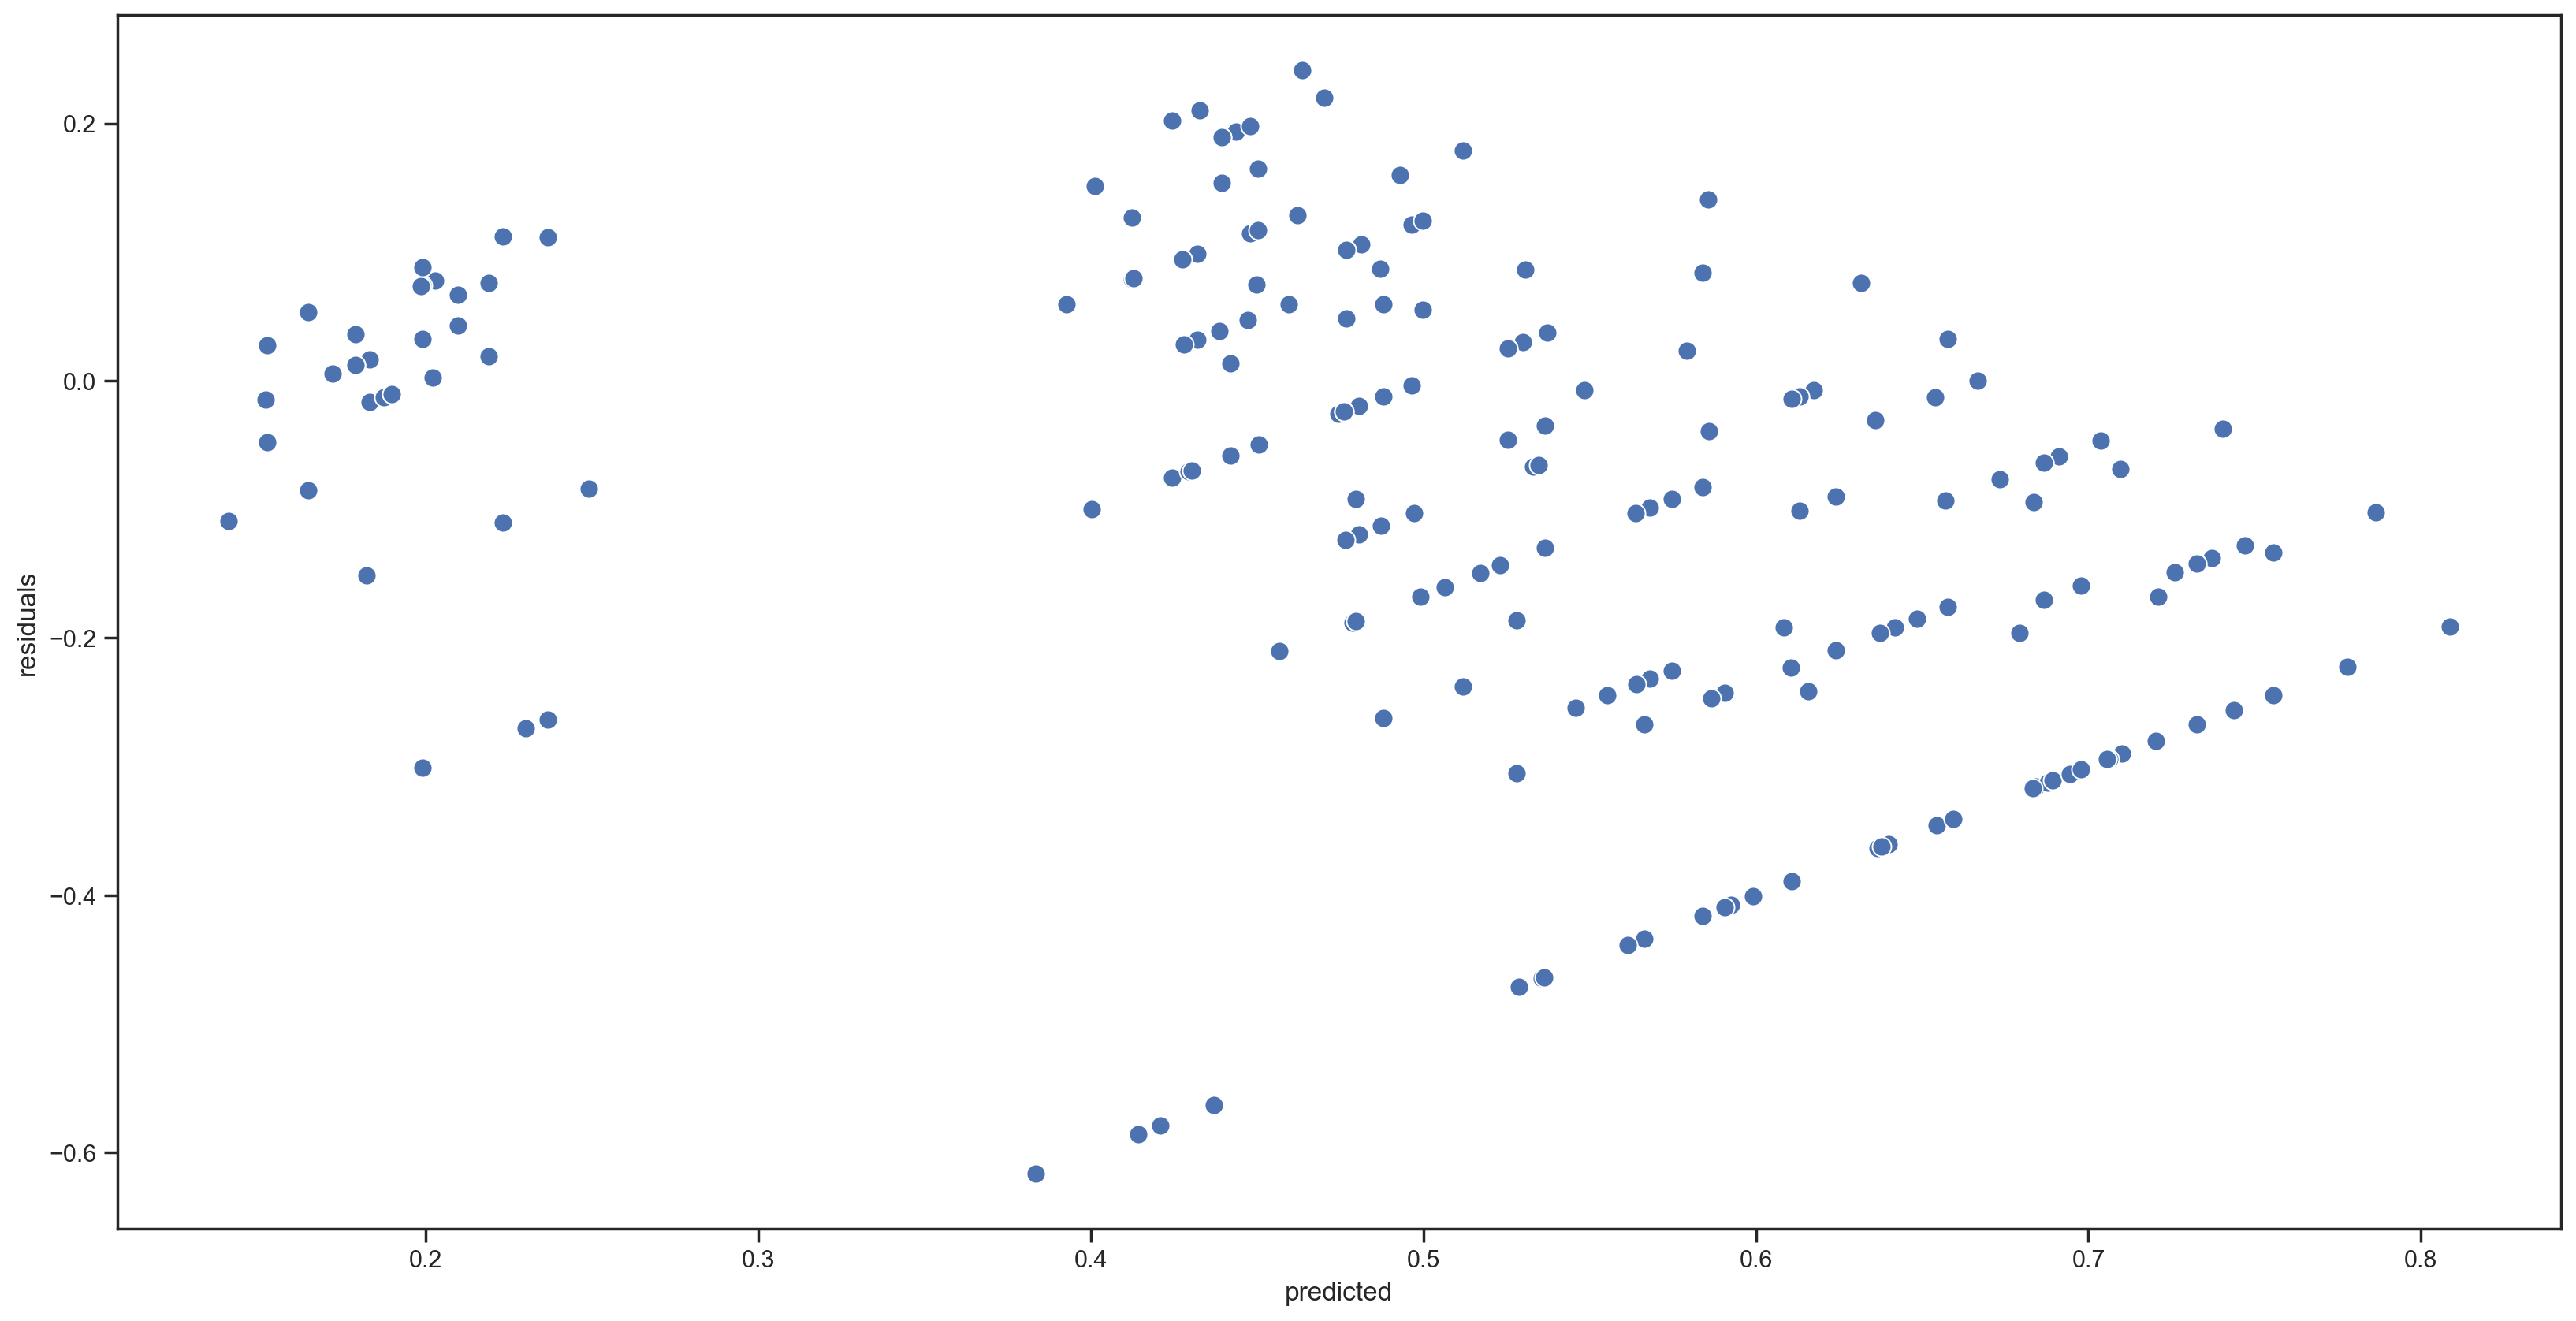

In [242]:
test_df["residuals"] = test_df["predicted"] - test_df["prob_of_release"]
sns.scatterplot(data=test_df, x="predicted", y="residuals", s=75)

In [243]:
sorted(zip(reg.feature_names_in_, reg.coef_), key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 0.1680787407129891),
 ('M_Sep', 0.03632840380520065),
 ('WD_Wednesday', 0.03315899873561605),
 ('WD_Thursday', 0.029902174043369426),
 ('M_Apr', 0.027382068891885453),
 ('M_Jul', 0.020438552265387967),
 ('M_Oct', 0.016064558624531832),
 ('M_Nov', 0.009335196996221524),
 ('WD_Tuesday', 0.008891422213564244),
 ('month_holidays', 0.008599591806702313),
 ('M_Jun', 0.0047726348584182),
 ('WD_Friday', 0.0028670095408360637),
 ('M_May', 0.0006507735147124187),
 ('M_Jan', -0.0013030267357916304),
 ('WD_Saturday', -0.016851822932872854),
 ('M_Dec', -0.019266077390829764),
 ('M_Aug', -0.021723031574938326),
 ('WD_Sunday', -0.028589490053590037),
 ('WD_Monday', -0.029378291651140084),
 ('M_Feb', -0.033170577922344194),
 ('M_Mar', -0.039509475292264076),
 ('previous_release_post', -0.21119484364208554)]

In [244]:
test_df[["prob_of_release", "predicted", "residuals"]].sort_values(by=["residuals"])

,prob_of_release,predicted,residuals
2112,1.000000,0.383386,-0.616614
1965,1.000000,0.414215,-0.585785
2091,1.000000,0.420863,-0.579137
1931,1.000000,0.437008,-0.562992
2028,1.000000,0.528709,-0.471291
...,...,...,...
2030,0.250000,0.447951,0.197951
1933,0.222222,0.424482,0.202259
2126,0.222222,0.432688,0.210466
2098,0.250000,0.470165,0.220165


## Predictions for the Next Week

In [245]:
last_release_date = test_df[test_df["prob_of_release"] == 1][-1:].iloc[0]["index"]
next_week = pandas.DataFrame([{"index" : t} for t in 
                              pandas.date_range(start=last_release_date, freq="1D", periods=8)])
next_week = next_week[1:].copy()
next_week["days_since_previous_release"] = range(1, len(next_week) + 1)
next_week["previous_release_post"] = [1, 0, 0, 0, 0, 0, 0]
next_week = get_features(next_week)

for f in features:
    if f not in next_week.columns:
        next_week[f] = 0
        
next_week[["days_since_previous_release", "month_holidays"]] = scaler.transform(
    next_week[["days_since_previous_release", "month_holidays"]])

In [246]:
next_week["predicted"] = reg.predict(next_week[features])

In [247]:
next_week[["index", "predicted"]]

,index,predicted
1,2023-01-05,0.226065
2,2023-01-06,0.459527
3,2023-01-07,0.489110
4,2023-01-08,0.526674
5,2023-01-09,0.575187
6,2023-01-10,0.662759
7,2023-01-11,0.736328
